In [2]:
import random

from graphviz import Digraph
import math
import numpy as np

In [3]:
class Value:
    def __init__(self, data, _children= (), _op='', label = ''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only integer or float accepted"
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad = other * (self.data**(other-1)) * out.grad
        out._backward = _backward
        
        return out
    
    def __truediv__(self, other):
        # 
        """other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data / other.data, (self, other), '/')
        def _backward():
            self.grad += (1/other.data) * out.grad
            
            other.grad += ((-1 * self.data) / (other.data**2)) * out.grad
        out._backward = _backward 
        
        return out"""
        return self * (other**-1)

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def exp(self):   # e^x
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def n_exp(self, other):   # n^x
        x = self.data
        n = other.data

        out = Value(n**x, (self, ), 'n^x')

        def _backward():
            self.grad += out.data * np.log(self.data) * out.grad   # d n^x = n^x * ln(x) * dx
        out._backward = _backward

        return out

    def backward(self):
        # Topological order of nodes
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0  # Seed the gradient

        for v in reversed(topo):
            v._backward()



In [4]:

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build (root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR - left to right

    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))

        dot.node(name = uid, label = "{ %s | data = %.4f | grad = %.4f}" % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            dot. edge(uid + n._op, uid)
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


In [5]:

a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b; e.label = 'e'
d = e+c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
g = Value(2.5, label = 'g')


L.grad = 1
d.grad = -2
f.grad = 4
e.grad = -2
c.grad = -2
b.grad = -4
a.grad = 6

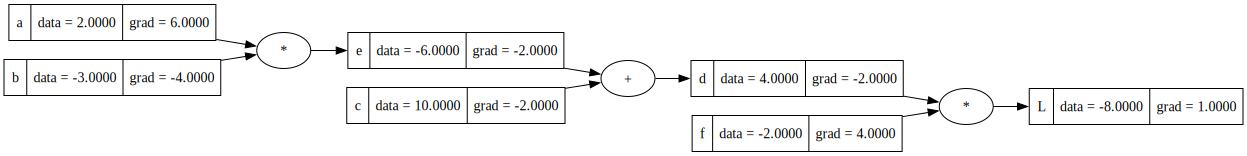

In [6]:
draw_dot(L)

In [7]:
# inputs x1,x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights w1,w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
bias = Value(6.8813735870195432, label = 'bias')
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + bias; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [8]:
# manually set the gradient of the loss function with respect to the output of the network
o.grad = 1
# do / dn = (tanh(n))' = 1 - (tanh(n))^2 = 1 - (0.7071)^2 = 0.5
n.grad = 0.5

x1w1x2w2.grad = 0.5
bias.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5
w2.grad = 0.0
x2.grad = 0.5

w1.grad = 1.0
x1.grad = -1.5

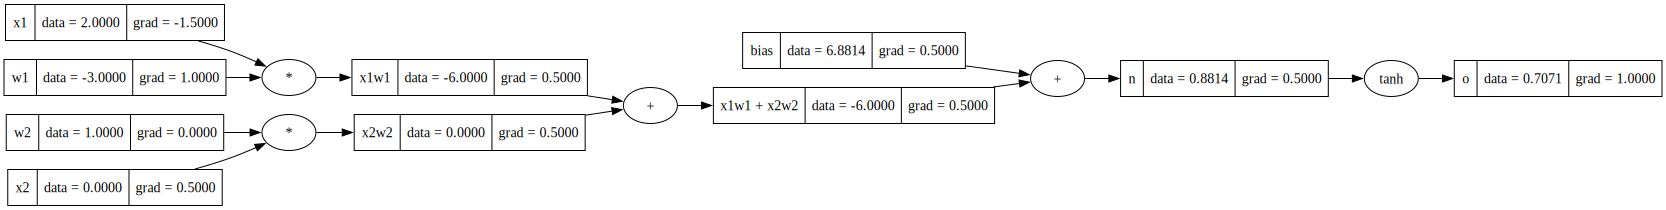

In [9]:
draw_dot(o)

In [10]:
# instead of manual setting of gradients, _backward method is used here.
# inputs x1,x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights w1,w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
bias = Value(6.8813735870195432, label = 'bias')
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + bias; n.label = 'n'
o = n.tanh(); o.label = 'o'

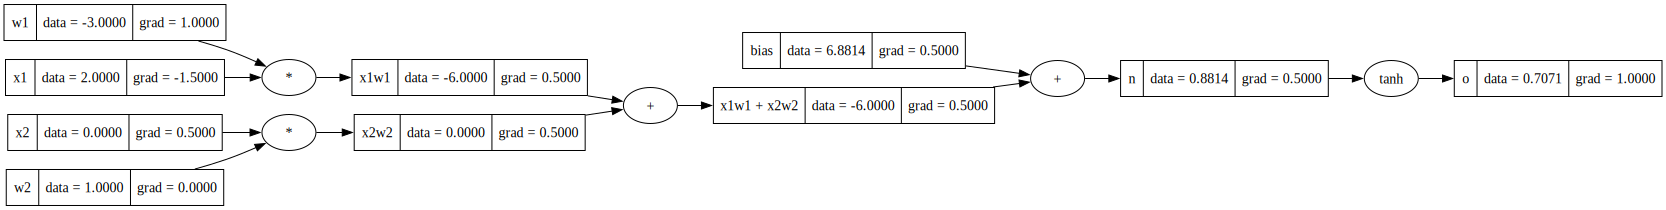

In [11]:
o.backward()

draw_dot(o)

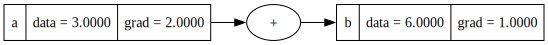

In [12]:
#testing multivariable bug
a = Value(3.0, label='a')
b = a + a; b.label = 'b'

b.backward()
draw_dot(b)
# grad of a is shown as 1, which is incorrect
#gradient should be accumulative, implementation of gradients have to change to +=

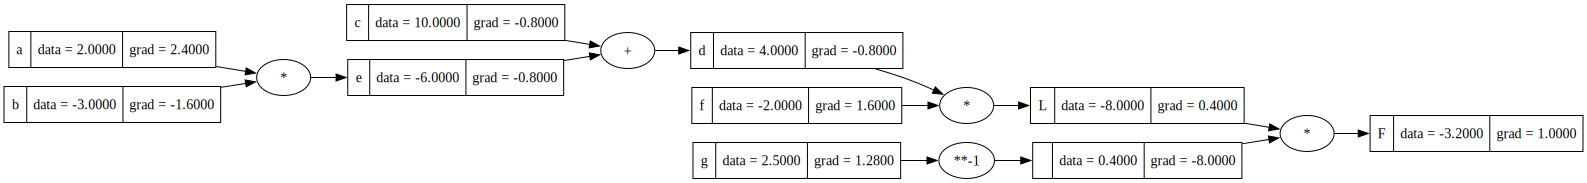

In [13]:
#testing division
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b; e.label = 'e'
d = e+c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
g = Value(2.5, label = 'g')
F = L / g; F.label = 'F'

F.backward()

draw_dot(F)

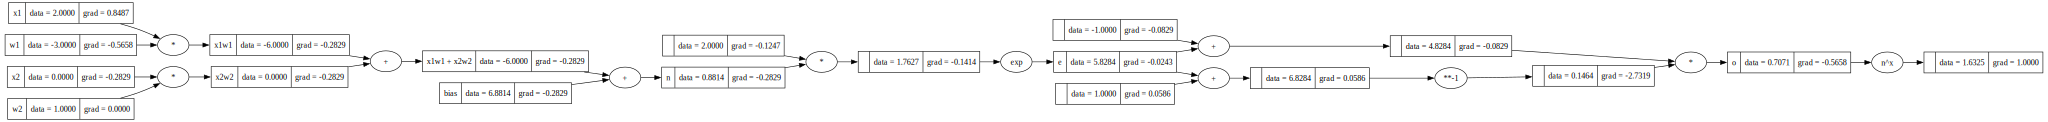

In [14]:
# inputs x1,x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights w1,w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
bias = Value(6.8813735870195432, label = 'bias')
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + bias; n.label = 'n'


e = (2*n).exp(); e.label = 'e'
o = (e - 1) / (e + 1); o.label = 'o'
f = o.n_exp(x1)
f.backward()
draw_dot(f)

In [15]:
x = Value(5.0, label = 'x')
y = Value(2.0, label = 'y')
z = x.n_exp(y)
z.backward()


In [16]:
import torch

In [17]:
x1 = torch.tensor([2.0]).double();  x1.requires_grad = True
x2 = torch.tensor([0.0]).double();  x2.requires_grad = True
w1 = torch.tensor([-3.0]).double();  w1.requires_grad = True
w2 = torch.tensor([1.0]).double();  w2.requires_grad = True
b = torch.tensor([6.8813735870195432]).double();  b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

0.7071066904050358


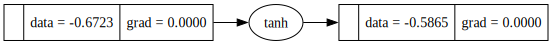

In [20]:
class Neuron:
    def __init__(self, nin):
        self.w = (Value(random.uniform(-1, 1)) for _ in range(nin))
        self.b = Value(random.uniform(-1, 1))
        
    def __call__(self, x):
        act = sum(( wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)
draw_dot(n(x))